In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from skimage import exposure
from scipy.stats import mode, norm

import scipy.stats as stats
import math

import seaborn as sns

from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 10,10

In [2]:
df = pd.read_csv('mnist_train.csv')

In [3]:
print("The dataframe:")
print(df.head())

#Look at the shape of data
print("Shape of data:")
print(df.shape)

The dataframe:
   label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
0      5    0    0    0    0    0    0    0    0    0  ...      0      0   
1      0    0    0    0    0    0    0    0    0    0  ...      0      0   
2      4    0    0    0    0    0    0    0    0    0  ...      0      0   
3      1    0    0    0    0    0    0    0    0    0  ...      0      0   
4      9    0    0    0    0    0    0    0    0    0  ...      0      0   

   28x21  28x22  28x23  28x24  28x25  28x26  28x27  28x28  
0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0  

[5 rows x 785 columns]
Shape of data:
(60000, 785)


In [4]:
#Let's look for null values

nan = df.isnull().sum()
print(nan[nan != 0])

Series([], dtype: int64)


No Null values

In [5]:
#Let's split the features and labels into different vectors
features = df.drop('label', axis = 1).values
labels = df['label'].values

y_train = df['label'].values

In [6]:
print('Feature shape:'+str(features.shape))
print('Labels shape:'+str(labels.shape))

Feature shape:(60000, 784)
Labels shape:(60000,)


In [7]:
#Reshape the feature vector into an image array
x_train = np.reshape(features, (-1,28,28))

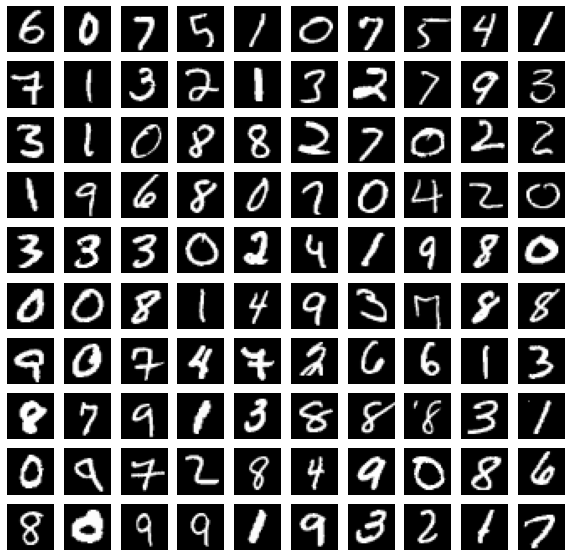

In [8]:
#visualize data
fig, ax = plt.subplots(nrows=10, ncols=10)
img = 0
plt.axis("off")
for row in ax:
    for col in row:
        col.imshow(x_train[np.random.randint(0,8000)], cmap = 'gray')
        col.axis('off')
        img+=1
plt.show()

In [9]:
count = df['label'].value_counts()
count.sort_index(axis = 0, inplace=True)

0    5923
1    6742
2    5958
3    6131
4    5842
5    5421
6    5918
7    6265
8    5851
9    5949
Name: label, dtype: int64


<BarContainer object of 10 artists>

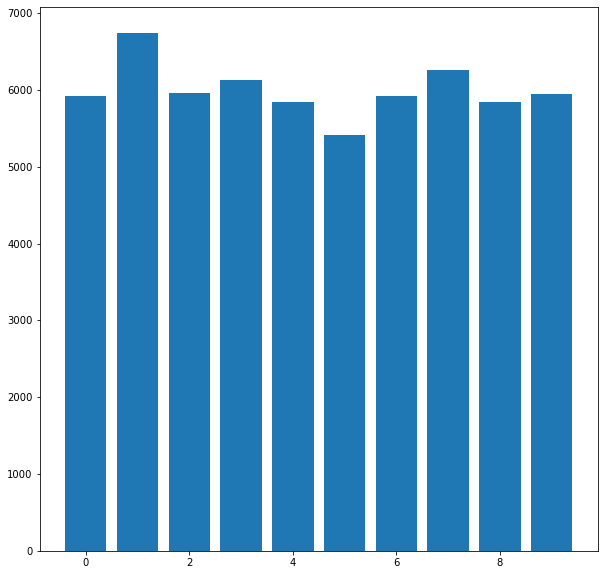

In [10]:
print(count)
plt.bar(count.index, count)

In [11]:
#Analyse the pixels intensity values
subset_pixels = df.iloc[:, 1:]
subset_pixels.describe()

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
count,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.0000,60000.0,60000.0,60000.0,60000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.200433,0.088867,0.045633,0.019283,0.015117,0.0020,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.042472,3.956189,2.839845,1.686770,1.678283,0.3466,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.000000,254.000000,62.0000,0.0,0.0,0.0,0.0


In [12]:
#Show histogram for each feature for an image
def show_image_and_histogram(img):
    fig, ax = plt.subplots(nrows = len(img), ncols=2)
    i = 0
    for row in ax:
        row[0].imshow(img[i].reshape(28,28), cmap=plt.cm.Greys)
        
        img_mode = mode(img[i]).mode[0] # leaving out all the values corresponding to zeros
        row[1].hist(list(filter(lambda x: x > img_mode, img[i].ravel())), bins=32, color='black')
        
        i+=1
    
    plt.xlabel('Pixel intensity')    

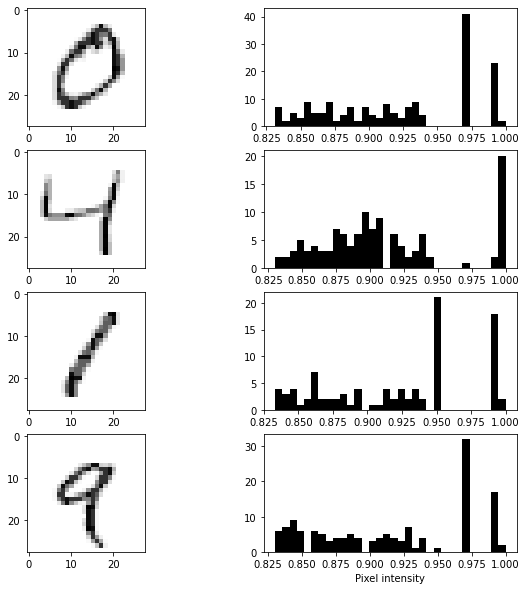

In [13]:
show_image_and_histogram(exposure.equalize_hist(features[1:5]))

In [14]:
def show_image_and_normal_curve(img):
    fig, ax = plt.subplots(nrows = len(img), ncols=3)
    i = 0
    norm_img = img/255.
    for row in ax:
        row[0].imshow(img[i].reshape(28,28), cmap=plt.cm.Greys)
        
        mu = np.mean(img[i],axis=0)
        sigma = np.std(img[i])
        
        domain = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
        
        print("Before Normalizing:")
        print(f'sigma{i} = {sigma} & mu{i} = {mu}')
        
        row[1].plot(domain, norm.pdf(domain,mu,sigma))
        
        mu = np.mean(norm_img[i],axis=0)
        sigma = np.std(norm_img[i])
        
        new_domain = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
        
        print("After Normalizing:")
        print(f'sigma{i} = {sigma} & mu{i} = {mu}\n')
        
        row[2].plot(domain, norm.pdf(new_domain,mu,sigma))
        
        i+=1
        
    plt.xlabel('Pixel intensity')      

Before Normalizing:
sigma0 = 83.88715868331147 & mu0 = 39.661989795918366
After Normalizing:
sigma0 = 0.32896924973847635 & mu0 = 0.15553721488595437

Before Normalizing:
sigma1 = 65.57974931595184 & mu1 = 24.799744897959183
After Normalizing:
sigma1 = 0.2571754875135366 & mu1 = 0.09725390156062426

Before Normalizing:
sigma2 = 66.0788867702743 & mu2 = 21.855867346938776
After Normalizing:
sigma2 = 0.25913288929519324 & mu2 = 0.08570928371348538

Before Normalizing:
sigma3 = 74.37131543202635 & mu3 = 29.60969387755102
After Normalizing:
sigma3 = 0.2916522173804955 & mu3 = 0.11611644657863145



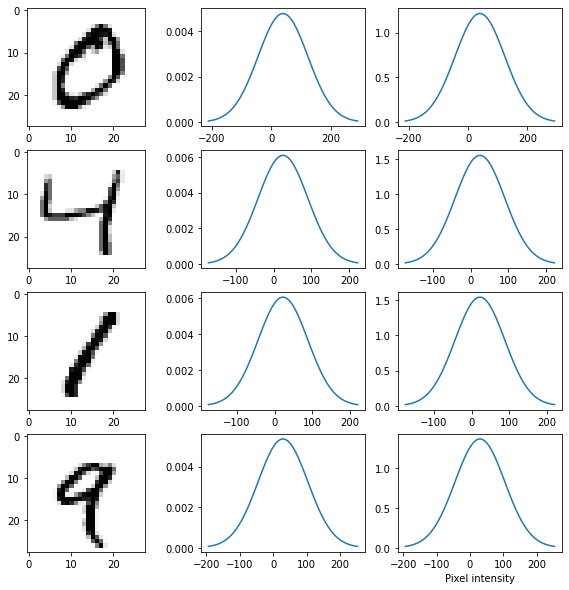

In [15]:
show_image_and_normal_curve(features[1:5])

Some pixels have always an intensity of 0 (max=0) or 255 (min=255)

# Lets reduce dimensions for proper visualization

Explained variation per principal component: [0.09717511 0.07019503]


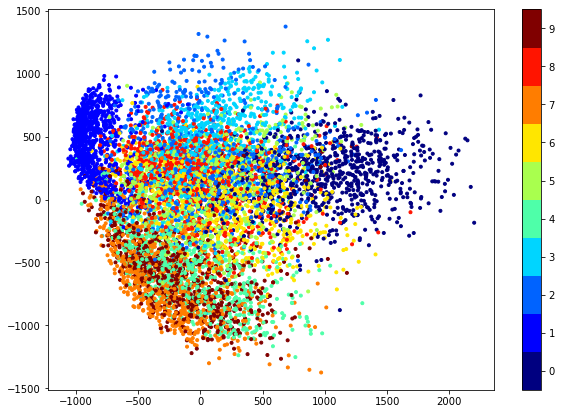

In [17]:
# Sample from the training set
sample_size = 8000

np.random.seed(2018)
idx = np.random.choice(60000, size=sample_size, replace=False)
train_sample = x_train.reshape(60000, -1)[idx, :]
label_sample = y_train[idx]

pca = PCA(n_components=2)
pca_result = pca.fit_transform(train_sample)
pca_vis_x = pca_result[:,0]
pca_vis_y = pca_result[:,1] 
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))


plt.figure(figsize=(10,7))
plt.scatter(pca_vis_x, pca_vis_y, c=label_sample, cmap=plt.cm.get_cmap("jet", 10), marker='.')
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8000 samples in 1.712s...
[t-SNE] Computed neighbors for 8000 samples in 81.417s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 443.208314
[t-SNE] Computed conditional probabilities in 0.866s
[t-SNE] Iteration 50: error = 95.0268402, gradient norm = 0.0003634 (50 iterations in 2.798s)
[t-SNE] Iteration 100: error = 87.5517502, gradient norm = 0.0022317 (50 iterations in 2.938s)
[t-SNE] Iteration 150: error = 86.5739059, gradient norm 

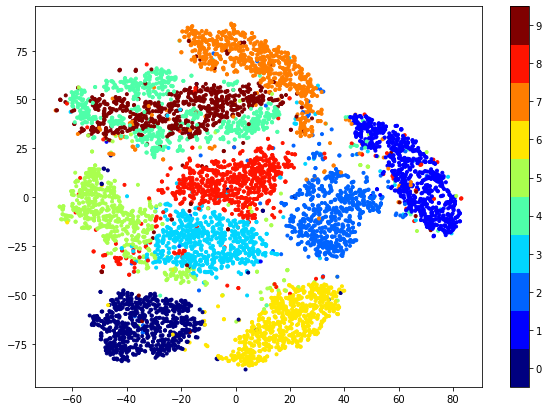

In [18]:
# Generate 2D embedding with TSNE
embeddings = TSNE(verbose=2).fit_transform(train_sample)

# Visualize TSNE embedding
tsne_vis_x = embeddings[:, 0]
tsne_vis_y = embeddings[:, 1]

plt.figure(figsize=(10,7))
plt.scatter(tsne_vis_x, tsne_vis_y, c=label_sample, cmap=plt.cm.get_cmap("jet", 10), marker='.')
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

# Data Preprocessing

In [19]:
def remove_constant_pixels(pixels_df):
    """Removes from the images the pixels that have a constant intensity value,
    either always black (0) or white (255)
    Returns the cleared dataset & the list of the removed pixels (columns)"""

    #Remove the pixels that are always black to compute faster
    changing_pixels_df = pixels_df.loc[:]
    dropped_pixels_b = []

    #Pixels with max value =0 are pixels that never change
    for col in pixels_df:
        if changing_pixels_df[col].max() == 0:
            changing_pixels_df.drop(columns=[col], inplace=True)
            dropped_pixels_b.append(col)
    print("Constantly black pixels that have been dropped: {}".format(dropped_pixels_b))


    #Same with pixels with min=255 (white pixels)
    dropped_pixels_w = []
    for col in changing_pixels_df:
        if changing_pixels_df[col].min() == 255:
            changing_pixels_df.drop(columns=[col], inplace=True)
            dropped_pixel_w.append(col)
    print("\n Constantly white pixels that have been dropped: {}".format(dropped_pixels_b))

    print(changing_pixels_df.head())
    print("Remaining pixels: {}".format(len(changing_pixels_df.columns)))
    print("Pixels removed: {}".format(784-len(changing_pixels_df.columns)))
    
    return changing_pixels_df, dropped_pixels_b + dropped_pixels_w

In [20]:
train_pixels_df = pd.read_csv('mnist_train.csv').drop(columns=['label'])
train_changing_pixels_df, dropped_pixels = remove_constant_pixels(train_pixels_df)

Constantly black pixels that have been dropped: ['1x1', '1x2', '1x3', '1x4', '1x5', '1x6', '1x7', '1x8', '1x9', '1x10', '1x11', '1x12', '1x17', '1x18', '1x19', '1x20', '1x21', '1x22', '1x23', '1x24', '1x25', '1x26', '1x27', '1x28', '2x1', '2x2', '2x3', '2x4', '2x25', '2x26', '2x27', '2x28', '3x1', '3x2', '3x27', '3x28', '4x1', '4x2', '4x28', '5x1', '6x1', '6x2', '7x1', '18x1', '21x1', '24x1', '24x2', '24x28', '25x1', '25x2', '25x28', '26x1', '26x2', '26x28', '27x1', '27x2', '27x3', '27x27', '27x28', '28x1', '28x2', '28x3', '28x4', '28x25', '28x26', '28x27', '28x28']

 Constantly white pixels that have been dropped: ['1x1', '1x2', '1x3', '1x4', '1x5', '1x6', '1x7', '1x8', '1x9', '1x10', '1x11', '1x12', '1x17', '1x18', '1x19', '1x20', '1x21', '1x22', '1x23', '1x24', '1x25', '1x26', '1x27', '1x28', '2x1', '2x2', '2x3', '2x4', '2x25', '2x26', '2x27', '2x28', '3x1', '3x2', '3x27', '3x28', '4x1', '4x2', '4x28', '5x1', '6x1', '6x2', '7x1', '18x1', '21x1', '24x1', '24x2', '24x28', '25x1', '25x

In [21]:
train_changing_pixels_df.head()

,1x13,1x14,1x15,1x16,2x5,2x6,2x7,2x8,2x9,2x10,...,28x15,28x16,28x17,28x18,28x19,28x20,28x21,28x22,28x23,28x24
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


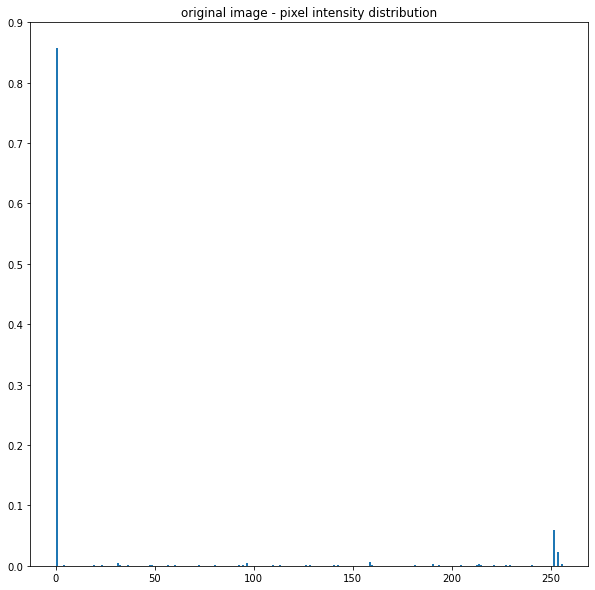

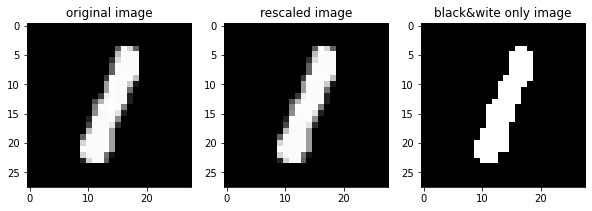

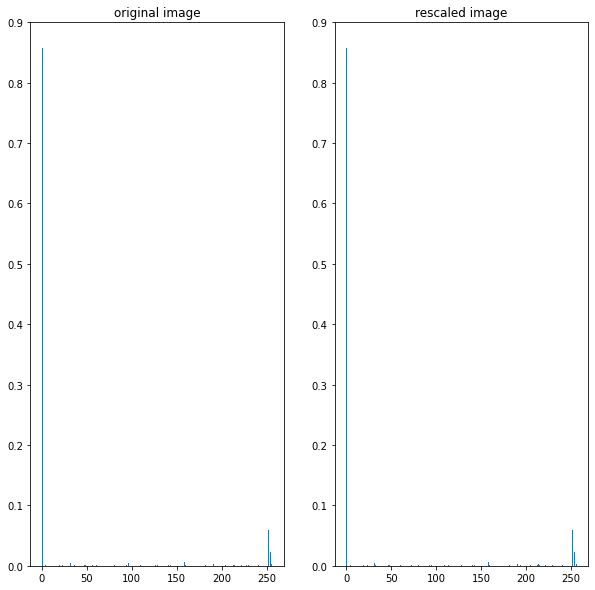

In [22]:
#Pick-up one random image from original training set
i = np.random.randint(low=0, high=42001, size=1).tolist()[0]
pixels = df.iloc[i, 1:]
image = df.iloc[i, 1:].values.reshape((28,28))

#Pixel intensity hstogram
plt.hist(pixels, bins=256, range=(0,256), density=True)
plt.title('original image - pixel intensity distribution')
plt.show()

#Rescaling the intensity
pmin, pmax = image.min(), image.max()
rescaled_image = 255*(image-pmin) / (pmax - pmin)
rescaled_pixels = rescaled_image.flatten()

#Only black or white pixels
bw_pixels = pixels.apply(lambda x: 0 if x<128 else 255)
bw_image = bw_pixels.values.reshape((28,28))


#Visual comparison of images
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('original image')
plt.subplot(1, 3, 2)
plt.imshow(rescaled_image, cmap='gray')
plt.title('rescaled image')
plt.subplot(1, 3, 3)
plt.imshow(bw_image, cmap='gray')
plt.title('black&wite only image')
plt.show()


#Visual Histogram comparison
plt.subplot(1, 2, 1)
plt.hist(pixels, bins=256, range=(0,256), density=True)
plt.title('original image')
plt.subplot(1, 2, 2)
plt.hist(rescaled_pixels, bins=256, range=(0,256), density=True)
plt.title('rescaled image')
plt.show()

Rescaling is not really useful because intensity distribution is not spread enough

In [23]:
from sklearn.preprocessing import StandardScaler, Normalizer, MaxAbsScaler
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV

In [25]:
#Sample randomly the dataset using discrete_uniform pick-up
sample = np.random.randint(low=0, high=42001, size=2100).tolist()

#Prepare the X (features) and y (label) arrays for the sampled images
X = train_changing_pixels_df.iloc[sample, :].values
y = df.loc[sample, 'label'].values#.reshape(-1,1)
print("Shape of X and Y arrays: {}".format((X.shape, y.shape)))

#Split the training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4, stratify=y)

#Fine tune the k value
param_grid = {'n_neighbors': np.arange(1,10)}
knn_cv = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
knn_cv.fit(X_train, y_train)

#Best k parameter
best_k = knn_cv.best_params_
best_accuracy = knn_cv.best_score_
print("Best accuracy on test set during training is {} obtained for {}".format(best_accuracy, best_k))

Shape of X and Y arrays: ((2100, 717), (2100,))
Best accuracy on test set during training is 0.8922619047619047 obtained for {'n_neighbors': 4}


# Logistic regression to classify numbers

In [26]:
# MNIST dataset parameters.

num_classes = 10 # 0 to 9 digits

num_features = 717 # The pre-processed data to remove redundant features

# Training parameters.

learning_rate = 1e-2

training_steps = 1000

batch_size = 256

display_step = 50

In [27]:
X_train = train_changing_pixels_df.values
y_train = df['label'].values

#Shuffle data for a more unbiased behaviour
train_data=tf.data.Dataset.from_tensor_slices((X_train,y_train))

train_data=train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [28]:
# Weight of shape [717, 10], the 28*28 image features minus the redundant pixels, and a total number of classes.

W = tf.Variable(tf.ones([num_features, num_classes]), name="weight")

# Bias of shape [10], the total number of classes.

b = tf.Variable(tf.zeros([num_classes]), name="bias")

In [29]:
# Logistic regression (Wx + b).

def logistic_regression(x):

    # Apply softmax to normalize the logits to a probability distribution.

    return tf.nn.softmax(tf.matmul(x, W) + b)

# Cross-Entropy loss function.
def cross_entropy(y_pred, y_true):

    # Encode label to a one hot vector.

    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.

    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Compute cross-entropy.

    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

In [30]:
# Accuracy metric.

def accuracy(y_pred, y_true):

# Predicted class is the index of the highest score in prediction vector (i.e. argmax).

    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))

    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Stochastic gradient descent optimizer.

optimizer = tf.optimizers.SGD(learning_rate)

In [31]:
# Optimization process. 

def run_optimization(x, y):

# Wrap computation inside a GradientTape for automatic differentiation.

    with tf.GradientTape() as g:

        pred = logistic_regression(x)

        loss = cross_entropy(pred, y)

    # Compute gradients.

    gradients = g.gradient(loss, [W, b])

  

    # Update W and b following gradients.

    optimizer.apply_gradients(zip(gradients, [W, b]))

In [32]:
# Run training for the given number of steps.

for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):

    # Run the optimization to update W and b values.
    
    batch_x = tf.cast(batch_x, tf.float32)
    batch_y = tf.cast(batch_y, tf.int32)

    run_optimization(batch_x, batch_y)

    

    if step % display_step == 0:

        pred = logistic_regression(batch_x)

        loss = cross_entropy(pred, batch_y)

        acc = accuracy(pred, batch_y)

        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
step: 50, loss: 2486.791992, accuracy: 0.531250
step: 100, loss: 2569.685059, accuracy: 0.515625
step: 150, loss: 2466.068848, accuracy: 0.535156
step: 200, loss: 2528.238770, accuracy: 0.523438
step: 250, loss: 2030.880127, accuracy: 0.617188
step: 300, loss: 2093.049805, accuracy: 0.605469
step: 350, loss: 2341.729004, accuracy: 0.558594
step: 400, loss: 2072.326660, accuracy: 0.609375
step: 450, loss: 1968.710327, accuracy: 0.628906
step: 500, loss: 2113.773193, accuracy: 0.601562
step: 550, loss: 2072.326660, accuracy: 0.609375
step: 600, loss: 2030.880127, accuracy: 0.617188
step: 650, loss: 2093.049805, accuracy: 0.605469
step: 700, loss: 1865.093994, accuracy: 0.648438
step: 750, loss: 2072.326660, accuracy: 0.609375
step: 800, loss: 2030.880127, accuracy: 0.617188
step: 850, loss: 2175.942871, accuracy: 0.589844
step: 900, loss: 2010.156860, accuracy: 0.621094
step: 950, loss: 1844.370